In [1]:
from datetime import timedelta

import holidays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold

from eli5.sklearn import PermutationImportance
import eli5

from optuna import create_study, Trial, visualization, progress_bar
from optuna.samplers import TPESampler
import optuna

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from tqdm.auto import tqdm

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_percentage_error_log(y_true, y_pred): 
    """
    predykcje na log
    """
    y_true, y_pred = np.array(np.expm1(y_true)), np.array(np.expm1(y_pred))
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
df = pd.read_csv("../input/energy_price.csv", parse_dates=["datetime"], index_col="datetime")

# brakujące daty
new_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
df = df.reindex(new_index)
df.sort_index(inplace=True) # raczej nie jest to potrzebne
df['is_test'] = df['is_test'].fillna(False)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29328 entries, 2019-06-28 00:00:00 to 2022-10-31 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   price    26253 non-null  float64
 1   is_test  29328 non-null  bool   
dtypes: bool(1), float64(1)
memory usage: 486.9 KB


### Własności daty

Zmienne, które można wygenerować w oparciu o datę

In [4]:
df['date_year'] = df.index.year
df['date_quarter'] = df.index.quarter
df['date_month'] = df.index.month
df['date_week'] = df.index.week
df['date_dayofweek'] = df.index.dayofweek
df['date_day'] = df.index.day
df['date_hour'] = df.index.hour

In [5]:
df['is_weekend'] = df.index.weekday.isin([5, 6]).astype(int)

In [6]:
pl_holidays = holidays.Poland(years=[2019, 2020, 2021, 2022])
df['is_holiday'] = df.index.isin(pl_holidays).astype(int)

In [7]:
def get_season(date):
    year = date.year
    seasons = {(year, 1, 1): 0, (year, 3, 20): 1, (year, 6, 21): 2, (year, 9, 22): 3, (year, 12, 21): 0}
    return seasons[max(filter(lambda x: x <= (year, date.month, date.day), seasons))]

df['season'] = df.index.map(get_season)

In [8]:
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 0
    elif 12 <= hour < 18:
        return 1
    elif 18 <= hour < 24:
        return 2
    else:
        return 3
df['time_of_day'] = df.index.hour.map(get_time_of_day)

In [9]:
def get_tariff(hour):
    if 6 <= hour < 22:
        return 1
    else:
        return 0
df['tariff'] = df.index.hour.map(get_tariff)

In [10]:
df['part_of_month'] = df.index.day.map(lambda day: 0 if day < 10 else 1 if day < 20 else 2)

### Lag

Wartości sprzed i*6 godzin, począwszy od 24 (1 dzień), a skończywszy na 28 dniach (~miesiąc)

In [11]:
for i in range(4, 4*8+1):
    df[f'lag_{i*6}_hours'] = df['price'].shift(i*6)

### Okienko danych
Cofam się o i dni i liczę statystyki na okienku od 1 do 7 dni wstecz

In [12]:
for window_size in [1, 2, 3, 4, 5, 6, 7]:
    for i in [1, 8]:
        df[f'rolling_{window_size}_days_shift_{i}_days_mean'] = df['price'].shift(i*24).rolling(window_size*24).mean()
        df[f'rolling_{window_size}_days_shift_{i}_days_std'] = df['price'].shift(i*24).rolling(window_size*24).std()
        df[f'rolling_{window_size}_days_shift_{i}_days_min'] = df['price'].shift(i*24).rolling(window_size*24).min()
        df[f'rolling_{window_size}_days_shift_{i}_days_max'] = df['price'].shift(i*24).rolling(window_size*24).max()
        df[f'rolling_{window_size}_days_shift_{i}_days_median'] = df['price'].shift(i*24).rolling(window_size*24).median()

### Zliczanie wartości

Ile wartości było większych od średnie/mediany w ostatnim tygodniu i w przedostatnim tygodniu

In [13]:
def count_higher_than_last_week_mean(series, df, date, i):
    last_week = df[(df.index < date - pd.Timedelta(days=i)) & (df.index >= date - pd.Timedelta(days=i+7))]
    if len(last_week) > 0:
        last_week_mean = last_week['price'].mean()
        return len([x for x in series if x > last_week_mean])
    else:
        return np.nan
    
def count_higher_than_last_week_median(series, df, date, i):
    last_week = df[(df.index < date - pd.Timedelta(days=i)) & (df.index >= date - pd.Timedelta(days=i+7))]
    if len(last_week) > 0:
        last_week_median = last_week['price'].median()
        return len([x for x in series if x > last_week_median])
    else:
        return np.nan

for window_size in [1, 7]:
    for i in [1]:
        df[f'rolling_{window_size}_days_shift_{i}_days_mean_high_price_count'] = df['price'].shift(i*24).rolling(window_size*24, min_periods=1).apply(lambda x: count_higher_than_last_week_mean(x, df, df.index[i], window_size))
        df[f'rolling_{window_size}_days_shift_{i}_days_median_high_price_count'] = df['price'].shift(i*24).rolling(window_size*24, min_periods=1).apply(lambda x: count_higher_than_last_week_median(x, df, df.index[i], window_size))

### Różności

In [14]:
# Różnice pomiędzy kolejnymi wartościami
df['price_diff'] = df['price'].shift(24).diff()
df['price_derivative'] = df['price'].shift(24).diff().diff()

In [15]:
# Największa / najmniejsza wartość do wczoraj
df['max_so_far'] = df['price'].shift(24).expanding().max()
df['min_so_far'] = df['price'].shift(24).expanding().min()

In [16]:
# Średnia krocząca z wykładzaniem wykładniczym
df['ema_1_12'] = df['price'].shift(1*24).ewm(span=12).mean()
df['ema_1_24'] = df['price'].shift(1*24).ewm(span=24).mean()
df['ema_7_6'] = df['price'].shift(7*24).ewm(span=6).mean()
df['ema_7_24'] = df['price'].shift(7*24).ewm(span=24).mean()
df['ema_8_6'] = df['price'].shift(8*24).ewm(span=6).mean()
df['ema_8_24'] = df['price'].shift(8*24).ewm(span=24).mean()

In [17]:
# Statystyki per
# - rok
# - rok i dzień tygodnia
# - rok, dzień tygodnia i godzina
for s in ['mean', 'median', 'std', 'min', 'max']:
    df[f'{s}_price_same_year'] = df.groupby(['date_year'])['price'].transform(s)
    df[f'{s}_price_same_year_dayofweek'] = df.groupby(['date_year', 'date_dayofweek'])['price'].transform(s)
    df[f'{s}_price_same_year_dayofweek_hour'] = df.groupby(['date_year', 'date_dayofweek', 'date_hour'])['price'].transform(s)

In [18]:
# statystyki w odniesieniu do poprzedniego roku

df['date_year_previous'] = df['date_year'] - 1

for s in ['mean', 'std']:
    yearly_stats = df.groupby(['date_year', 'date_dayofweek', 'date_hour'])['price'].agg(s).reset_index()
    yearly_stats.columns = ['date_year', 'date_dayofweek', 'date_hour', f'{s}_price_previous_year_dayofweek_hour']

    df = df.reset_index()
    df = pd.merge(df, yearly_stats, how='left', left_on=['date_year_previous', 'date_dayofweek', 'date_hour'], right_on=['date_year', 'date_dayofweek', 'date_hour'])
    df.drop(columns='date_year_y', inplace=True)
    df.rename(columns={'date_year_x': 'date_year'}, inplace=True)
    df = df.rename(columns={'index': 'datetime'})
    df.index = df['datetime']
    df = df.drop(columns=['datetime'])
    
df['date_year_previous'] = df['date_year'] - 1

for s in ['mean', 'std']:
    yearly_stats = df.groupby(['date_year', 'date_dayofweek'])['price'].agg(s).reset_index()
    yearly_stats.columns = ['date_year', 'date_dayofweek', f'{s}_price_previous_year_dayofweek']

    df = df.reset_index()
    df = pd.merge(df, yearly_stats, how='left', left_on=['date_year_previous', 'date_dayofweek'], right_on=['date_year', 'date_dayofweek'])
    df.drop(columns='date_year_y', inplace=True)
    df.rename(columns={'date_year_x': 'date_year'}, inplace=True)
    df = df.rename(columns={'index': 'datetime'})
    df.index = df['datetime']
    df = df.drop(columns=['datetime'])
    
df['date_year_previous'] = df['date_year'] - 1

for s in ['mean', 'std']:
    yearly_stats = df.groupby(['date_year', 'date_month', 'date_hour'])['price'].agg(s).reset_index()
    yearly_stats.columns = ['date_year', 'date_month', 'date_hour', f'{s}_price_previous_year_month_hour']

    df = df.reset_index()
    df = pd.merge(df, yearly_stats, how='left', left_on=['date_year_previous', 'date_month', 'date_hour'], right_on=['date_year', 'date_month', 'date_hour'])
    df.drop(columns='date_year_y', inplace=True)
    df.rename(columns={'date_year_x': 'date_year'}, inplace=True)
    df = df.rename(columns={'index': 'datetime'})
    df.index = df['datetime']
    df = df.drop(columns=['datetime'])
    
df['date_year_previous'] = df['date_year'] - 1

for s in ['mean', 'std']:
    yearly_stats = df.groupby(['date_year', 'date_month'])['price'].agg(s).reset_index()
    yearly_stats.columns = ['date_year', 'date_month', f'{s}_price_previous_year_month']

    df = df.reset_index()
    df = pd.merge(df, yearly_stats, how='left', left_on=['date_year_previous', 'date_month'], right_on=['date_year', 'date_month'])
    df.drop(columns='date_year_y', inplace=True)
    df.rename(columns={'date_year_x': 'date_year'}, inplace=True)
    df = df.rename(columns={'index': 'datetime'})
    df.index = df['datetime']
    df = df.drop(columns=['datetime'])

In [19]:
# zabawy z procentami
for i in [1]:
    for j in range(1, 25):
        df[f'change_{i}_{j}'] = df['price'].shift(i*24).pct_change(j)
        
df['cumulative_change_7'] = df['price'].shift(24).pct_change(24*7)
df['cumulative_change_28'] = df['price'].shift(24).pct_change(24*28)
df['cumulative_change_91'] = df['price'].shift(24).pct_change(24*91)
df['cumulative_change_365'] = df['price'].shift(24).pct_change(24*365)

df['price_ratio_1'] = df['price'].shift(24) / df['price'].shift(24*2)
df['price_ratio_7'] = df['price'].shift(24) / df['price'].shift(24*7) 
df['price_ratio_28'] = df['price'].shift(24) / df['price'].shift(24*28) 
df['price_ratio_91'] = df['price'].shift(24) / df['price'].shift(24*91) 
df['price_ratio_365'] = df['price'].shift(24) / df['price'].shift(24*365) 

In [20]:
# zmiana względem potencjalnego max (wtorek) i min (sobota)

df['weekday'] = df.index.weekday
df_daily = df['price'].resample('D').mean().to_frame()
df_daily['weekday'] = df['weekday'].resample('D').first()
df_daily['avg_change_prev_sat_tue'] = np.nan
df_daily['avg_change_tue_next_sat'] = np.nan
df_daily['avg_change_from_last_tue'] = np.nan
df_daily['avg_change_from_last_sat'] = np.nan

# szukamy indeksów wtorków i sobót
tuesdays = df_daily[df_daily['weekday'] == 1].index
saturdays = df_daily[df_daily['weekday'] == 5].index

for i in range(0, len(tuesdays)-2): 
    # sbliczamy średnią dzienną zmianę ceny od wtorku do soboty i od soboty do wtorku
    if tuesdays[i-1] in df_daily.index and saturdays[i-1] in df_daily.index and tuesdays[i] in df_daily.index and saturdays[i] in df_daily.index:
        price_diff_prev_sat_tue = df_daily.loc[tuesdays[i], 'price'] - df_daily.loc[saturdays[i], 'price']
        price_diff_tue_next_sat = df_daily.loc[saturdays[i+1], 'price'] - df_daily.loc[tuesdays[i], 'price']
        
        df_daily.loc[(tuesdays[i]+timedelta(days=8)):(tuesdays[i+1]+timedelta(days=8)), 'avg_change_prev_sat_tue'] = price_diff_prev_sat_tue / 3
        df_daily.loc[(saturdays[i+1]+timedelta(days=8)):(saturdays[i+2]+timedelta(days=8)), 'avg_change_tue_next_sat'] = price_diff_tue_next_sat / 4


for i in range(0, len(tuesdays)-1): 
    # Obliczamy średnią dzienną zmianę ceny od ostatniego wtorku/soboty do dnia przed danym dniem
    if tuesdays[i-1] in df_daily.index and saturdays[i-1] in df_daily.index and tuesdays[i] in df_daily.index and saturdays[i] in df_daily.index:
        for j in pd.date_range(start=tuesdays[i] + pd.DateOffset(days=1), end=tuesdays[i+1]):
            price_diff_from_last_tue = df_daily.loc[j, 'price'] - df_daily.loc[tuesdays[i], 'price']
            df_daily.loc[j+pd.DateOffset(days=1), 'avg_change_from_last_tue'] = price_diff_from_last_tue / (j - tuesdays[i]).days

        for j in pd.date_range(start=saturdays[i] + pd.DateOffset(days=1), end=saturdays[i+1]):
            price_diff_from_last_sat = df_daily.loc[j, 'price'] - df_daily.loc[saturdays[i], 'price']
            df_daily.loc[j+pd.DateOffset(days=1), 'avg_change_from_last_sat'] = price_diff_from_last_sat / (j - saturdays[i]).days
            
df_daily['date_year'] = df_daily.index.year
df_daily['date_month'] = df_daily.index.month
df_daily['date_day'] = df_daily.index.day

df = df.reset_index().merge(df_daily[['date_year', 'date_month', 'date_day', 
                   'avg_change_prev_sat_tue', 'avg_change_tue_next_sat', 'avg_change_from_last_tue', 'avg_change_from_last_sat']], 
         how='left', on=['date_year', 'date_month', 'date_day'])
df = df.set_index(df.datetime)
df.drop(columns=['datetime'], inplace=True)

In [21]:
# usuwam zmienne, które mają co najmniej 3 dni braków na zbiorze testowym
for f in [x for x in df.columns if x not in ['price', 'price_log', 'date_day', 'weekday', 'is_test']]:
    if df[df.is_test][f].isna().sum() > 48:
        print(f, df[df.is_test][f].isna().sum())
        df.drop(columns = f)

rolling_1_days_shift_1_days_mean_high_price_count 720
rolling_1_days_shift_1_days_median_high_price_count 720
rolling_7_days_shift_1_days_mean_high_price_count 720
rolling_7_days_shift_1_days_median_high_price_count 720
price_ratio_28 120
price_ratio_365 72


### Logarytmy
Sporo rozkładów jest skośnych, ale teoretycznie nie działa to na xgboost, lightgbm ani catboost

In [22]:
for c in [x for x in df.columns if (x[:4] == 'lag_') | (x[:8] == 'rolling_')]:
    df[f'{c}_log'] = np.log1p(df[c])

### Zmienna celu jako logarytm
Tutaj akurat to pomaga

In [23]:
df['price_log'] = np.log1p(df['price'])

## Model Selection

In [24]:
# 2020 jest bardzo stabilny
# pierwszy dostępny rok tylko na potrzeby policzenia statystyk
df = df[(df.date_year >= 2020)]

In [25]:
df_train = df[~df['is_test'] & ~df['price'].isna()].drop(columns='is_test')
df_test  = df[df['is_test']].drop(columns='is_test')

# Pewnie możnaby to fajniej zrobić
df_train.fillna(-1, inplace=True)
df_test.fillna(-1, inplace=True)

Test kilku modeli

In [26]:
target = 'price_log'
feats = [x for x in df_train.columns if x not in ['price', 'price_log', 'date_day', 'weekday', 'is_test']]

X = df_train[feats]
y = df_train[target]

# Define groups based on day
groups = df_train['date_day']

# Initialize GroupKFold
gkf = GroupKFold(n_splits=5)

models = [
    ('XGBoost', XGBRegressor(random_state=42)),
    ('LightGBM', LGBMRegressor(random_state=42)),
    ('CatBoost', CatBoostRegressor(random_state=42, verbose=0)),
]

for name, model in models:
    mape_scores = []
    for train_idx, test_idx in gkf.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mape = mean_absolute_percentage_error_log(y_test, predictions)
        print(mape)
        mape_scores.append(mape)
    print(f'{name} Average MAPE: {np.mean(mape_scores)}')

14.345944953863013
13.499050710080137
14.275667296769297
12.784011178674081
14.099281520773285
XGBoost Average MAPE: 13.800791132031964
13.717950224452267
12.973119164606844
14.11684107802795
12.518834125305006
13.607984285714553
LightGBM Average MAPE: 13.386945775621323
13.514207872686473
12.96280644885095
13.368547414054706
12.077861677819214
13.114047447154755
CatBoost Average MAPE: 13.007494172113221


## Features Selection

In [27]:
target = 'price_log'
feats = [x for x in df_train.columns if x not in ['price', 'price_log', 'date_day', 'weekday', 'is_test']]

X = df_train[feats]
y = df_train[target]

# Define groups based on day
groups = df_train['date_day']

# Initialize GroupKFold
gkf = GroupKFold(n_splits=5)

# Define your model
model = XGBRegressor(random_state=42)

# Permutation importance results will be stored in this dataframe
importances = pd.DataFrame()

# Apply group k-fold cross-validation
for train_idx, test_idx in gkf.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Calculate permutation importances
    perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
    
    # Get importances
    imp_df = eli5.explain_weights_df(perm, feature_names = X_test.columns.tolist())
    importances = pd.concat([importances, imp_df])
    
    print(imp_df.head(20))

# Average feature importances over all splits
average_importances = importances.groupby('feature').mean().sort_values(by='weight', ascending=False)

print(average_importances)

In [28]:
average_importances.head(30).index.tolist()

## Parameters optimization

In [29]:
target = 'price_log'
feats = [
    'max_so_far',
    'lag_24_hours',
    'ema_7_6',
    'ema_1_12',
    'mean_price_same_year_dayofweek_hour',
    'std_price_same_year_dayofweek_hour',
    'mean_price_previous_year_month_hour',
    'median_price_same_year_dayofweek_hour',
    'avg_change_from_last_tue',
    'date_week',
    'lag_168_hours',
    'lag_72_hours',
    'lag_144_hours',
    'min_price_same_year_dayofweek_hour',
    'rolling_7_days_shift_1_days_std',
    'lag_96_hours',
    'rolling_5_days_shift_8_days_median',
    'date_dayofweek',
    'rolling_7_days_shift_1_days_mean',
    'std_price_previous_year_month',
    'rolling_3_days_shift_8_days_min',
    'rolling_1_days_shift_1_days_std',
    'rolling_3_days_shift_1_days_max',
    'min_price_same_year_dayofweek',
    'rolling_6_days_shift_8_days_min',
    'max_price_same_year_dayofweek_hour',
    'avg_change_from_last_sat',
    'rolling_1_days_shift_8_days_median',
    'rolling_3_days_shift_8_days_median',
    'season'
]

In [30]:
X = df_train[feats]
y = df_train[target]

# Define groups based on day
groups = df_train['date_day']

# Initialize GroupKFold
gkf = GroupKFold(n_splits=5)

def objective(trial: Trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.03, 0.15),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    }
    
    model = XGBRegressor(**params, random_state=42)

    mape_scores = []

    for train_idx, test_idx in gkf.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mape = mean_absolute_percentage_error_log(y_test, predictions)
        mape_scores.append(mape)
    
    return np.mean(mape_scores)

study = create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

In [31]:
params = {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.815}

X = df_train[feats]
y = df_train[target]

# Define groups based on day
groups = df_train['date_day']

# Initialize GroupKFold
gkf = GroupKFold(n_splits=5)

models = [
    ('XGBoost', XGBRegressor(**params, random_state=42)),
#     ('LightGBM', LGBMRegressor(random_state=42)),
#     ('CatBoost', CatBoostRegressor(random_state=42, verbose=0)),
]

for name, model in models:
    mape_scores = []
    for train_idx, test_idx in gkf.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mape = mean_absolute_percentage_error_log(y_test, predictions)
        print(mape)
        mape_scores.append(mape)
    print(f'{name} Average MAPE: {np.mean(mape_scores)}')

12.941957072313324
12.820780705585896
13.327624197272744
12.861287376135158
12.793940310958247
XGBoost Average MAPE: 12.949117932453072


## Submission

In [33]:
X = df_train[feats]
y = df_train[target]

# Define groups based on day
groups = df_train['date_day']

# Initialize GroupKFold
gkf = GroupKFold(n_splits=5)

# This will store your final predictions
valid_predictions = np.zeros(len(df_train))
final_predictions = np.zeros(len(df_test))

# Apply K-fold cross validation
for train_idx, test_idx in gkf.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train the model
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    
    # TEST 
    print(mean_absolute_percentage_error_log(y_test, model.predict(X_test[feats])))
    
    # TEST na wykres 
    pred = model.predict(df_train[feats])  
    valid_predictions += np.expm1(pred) / gkf.get_n_splits()
    
    # Make predictions on the validation set
    predictions = model.predict(df_test[feats])
    
    # Average the predictions
    final_predictions += np.expm1(predictions) / gkf.get_n_splits()

# Print or do something with the final predictions
df_train['pred_price'] = valid_predictions
df_test['pred_price'] = final_predictions

12.941957072313324
12.820780705585896
13.327624197272744
12.861287376135158
12.793940310958247


TEST

In [34]:
def plot_compare_stats(df1, df2, f, t, p='D'):
    df1_daily_mean = df1[(df1.index >= f) & (df1.index <= t)].resample(p).mean()
    df2_daily_mean = df2[(df2.index >= f) & (df2.index <= t)].resample(p).mean()

    # not nan
    A = df1_daily_mean[df1_daily_mean['price'] > 0]['price']
    B = df1_daily_mean[df1_daily_mean['pred_price'] > 0]['pred_price']
    C = df2_daily_mean[df2_daily_mean['pred_price'] > 0]['pred_price']

    plt.figure(figsize=(14, 8))
    plt.plot(A.index, A, color='black', label='price')
    plt.plot(B.index, B, color='green', label='pred price')
    plt.scatter(C.index, C, color='red', label='submit price')

    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title(f'Mean Energy Prices in Poland')
    plt.legend()
    plt.show()

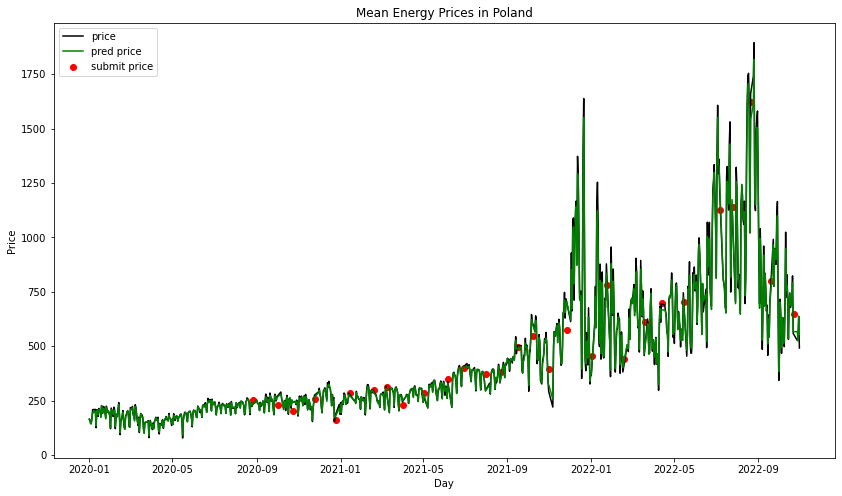

In [35]:
plot_compare_stats(df_train, df_test, f='2020-01-01 00:00:00', t='2022-12-31 23:00:00')

In [38]:
submit = df_test[['pred_price']].reset_index().rename(columns={'pred_price': 'price', 'index': 'datetime'})
submit.to_csv("xgb_model_MAPE_12_submit.csv", index=False)

In [37]:
submit

,datetime,price
0,2020-08-27 00:00:00,218.509827
1,2020-08-27 01:00:00,212.580551
2,2020-08-27 02:00:00,208.460850
3,2020-08-27 03:00:00,205.896275
4,2020-08-27 04:00:00,203.094666
...,...,...
715,2022-10-23 19:00:00,850.699631
716,2022-10-23 20:00:00,784.659637
717,2022-10-23 21:00:00,687.739487
718,2022-10-23 22:00:00,684.090134


Wynik na Kaggle

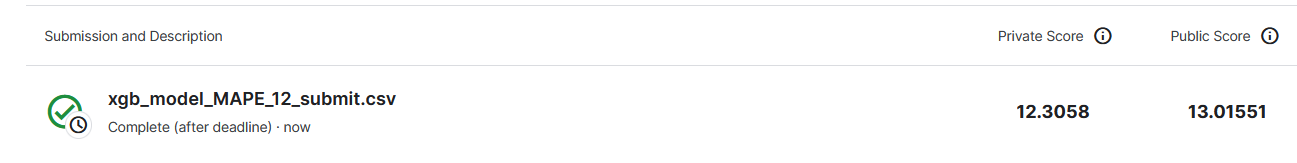